In [ ]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds

dataset, info = tfds.load('oxford_iiit_pet:3.2.0', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete3U0JIG/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete3U0JIG/oxford_iiit_pet-test.tfrecord


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.2.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Ja

In [ ]:
train_data_len = info.splits['train'].num_examples
test_data_len = info.splits['test'].num_examples

In [ ]:
import tensorflow as tf
def load_image(datapoint):
  img = tf.image.resize(datapoint['image'],(128,128))
  mask = tf.image.resize(datapoint['segmentation_mask'],(128,128))

  img = tf.cast(img, tf.float32)
  img = img/255.0
  mask = mask -1

  return img, mask

In [ ]:
train_dataset = dataset['train'].map(load_image)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(16)

test_dataset = dataset['test'].map(load_image)
test_dataset = test_dataset.repeat()
test_dataset = test_dataset.batch(1)

0.3996089 0.00047392002


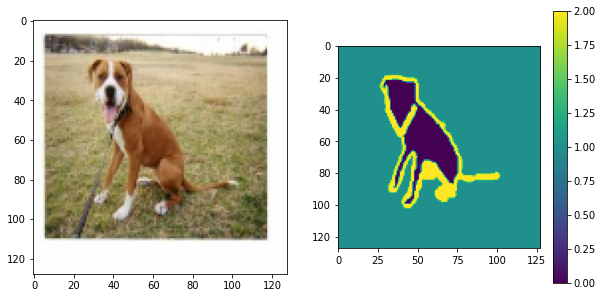

In [ ]:
import matplotlib.pyplot as plt

for img, mask in train_dataset.take(1): #take(1) = 하나만
  plt.figure(figsize=(10,5))

  plt.subplot(1,2,1)
  plt.imshow(img[5])

  plt.subplot(1,2,2)
  plt.imshow(np.squeeze(mask[5], axis=2))   # squeeze(배열, 축)= 지정된 축을 제거/ axis=2 : 2차원 축 제거
  plt.colorbar()

  print(np.amax(img[1][2]), np.amin(img[1][2]))

In [ ]:
 def REDNet_segmentation(num_layers):
  conv_layers=[] 
  deconv_layers = []
  residual_layers=[]

  inputs = tf.keras.layers.Input(shape=(None, None,3))
  conv_layers.append(tf.keras.layers.Conv2D(3, kernel_size=3, padding='same', activation='relu'))

  for i in range(num_layers - 1):
    conv_layers.append(tf.keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='relu'))
    deconv_layers.append(tf.keras.layers.Conv2DTranspose(64, kernel_size=3, padding='same', activation='relu'))

  deconv_layers.append(tf.keras.layers.Conv2DTranspose(3, kernel_size=3, padding='same', activation='softmax'))
  
  x = conv_layers[0](inputs)
  
  for i in range(num_layers-1):
    x = conv_layers[i+1](x)
    if i % 2 == 0:
      residual_layers.append(x)

  for i in range(num_layers -1):
    if i %2 == 1:
      x = tf.keras.layers.Add()([x, residual_layers.pop()])
      x = ft.keras.layers.Activation('relu')(x)
    x = deconv_layers[i](x)

  x = deconv_layers[-1](x)

  model = tf.keras.Model(inputs = inputs, outputs =x)
  return model

In [ ]:
model = REDNet_segmentation(15)
model.summary()

model.compile(loss='sparse_categorical_crossentropy', optimizer = tf.optimizers.Adam(0.0001), metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, None, None, 3 84          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, None, None, 6 1792        conv2d_15[0][0]                  
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, None, None, 6 36928       conv2d_16[0][0]                  
______________________________________________________________________________________________

In [23]:
%%time
Hist = model.fit(train_dataset, epochs=20, steps_per_epoch=train_data_len//16, validation_data=test_dataset, validation_steps=test_data_len)

Epoch 1/20
230/230 [==============================] - 477s 2s/step - loss: 0.9282 - accuracy: 0.5799 - val_loss: 0.8065 - val_accuracy: 0.6251
Epoch 2/20
230/230 [==============================] - 445s 2s/step - loss: 0.7501 - accuracy: 0.6535 - val_loss: 0.7384 - val_accuracy: 0.6724
Epoch 3/20
230/230 [==============================] - 443s 2s/step - loss: 0.6895 - accuracy: 0.6947 - val_loss: 0.6739 - val_accuracy: 0.7094
Epoch 4/20
230/230 [==============================] - 442s 2s/step - loss: 0.6404 - accuracy: 0.7237 - val_loss: 0.6296 - val_accuracy: 0.7330
Epoch 5/20
230/230 [==============================] - 444s 2s/step - loss: 0.6026 - accuracy: 0.7421 - val_loss: 0.5964 - val_accuracy: 0.7499
Epoch 6/20
230/230 [==============================] - 443s 2s/step - loss: 0.5720 - accuracy: 0.7577 - val_loss: 0.5654 - val_accuracy: 0.7619
Epoch 7/20
230/230 [==============================] - 443s 2s/step - loss: 0.5535 - accuracy: 0.7667 - val_loss: 0.5410 - val_accuracy: 0.7729

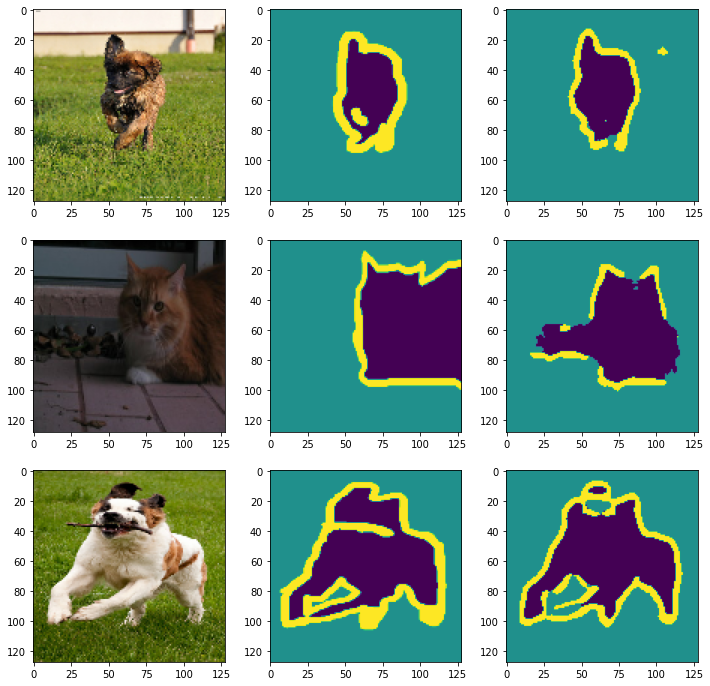

In [30]:
plt.figure(figsize=(12,12))

for idx, (img,mask) in enumerate(test_dataset.take(3)):
  plt.subplot(3,3, idx*3 +1)
  plt.imshow(img[0])

  plt.subplot(3,3, idx*3+2)
  plt.imshow(np.squeeze(mask[0], axis=2))

  predict=tf.argmax(model.predict(img), axis=-1)
  plt.subplot(3,3, idx*3+3)
  plt.imshow(np.squeeze(predict, axis=0))

ValueError: ignored

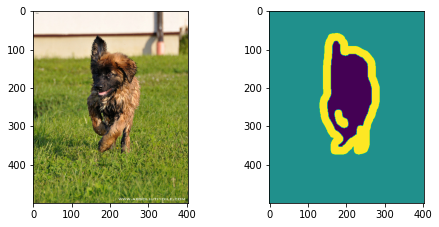

In [31]:
plt.figure(figsize=(12,12))

for idx, datapoint in enumerate(dataset['test'].take(3)):
  img = datapoint['image']
  mask = datapoint['segmentation_mask']

  img = tf.cast(img, tf.float32)
  img = img/255.0
  #mask = mask-1

  plt.subplot(3,3, idx*3+1)
  plt.imshow(img)

  plt.subplot(3,3, idx*3+2)
  plt.imshow(np.squeeze(mask, axis=2))

  predict = tf.argmax(model.predict(img), axis=-1)
  plt.subplot(3,3, idx*3+3)
  plt.imshow(np.squeeze(predict, axis=0))